In [974]:
import osmnx as ox

# Define the location you want (can be a city, district, state, etc.)
location = "bhopal, madhya pradesh, India"  # You can change this to any place

# Get the boundary as a GeoDataFrame
gdf = ox.geocode_to_gdf(location)

# Save to GeoJSON file
gdf.to_file("prayagraj_area.geojson", driver="GeoJSON")

print("✅ GeoJSON boundary saved as 'your_area.geojson'")

✅ GeoJSON boundary saved as 'your_area.geojson'


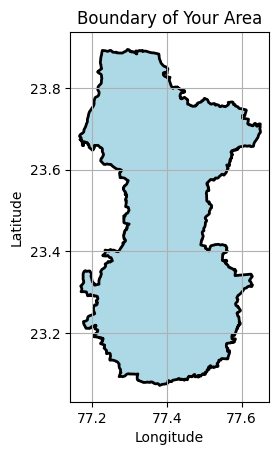

In [975]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON file
gdf = gpd.read_file("prayagraj_area.geojson")
# print(type(gdf))
# Plot it
gdf.plot(edgecolor='black', facecolor='lightblue', linewidth=2)
plt.title("Boundary of Your Area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

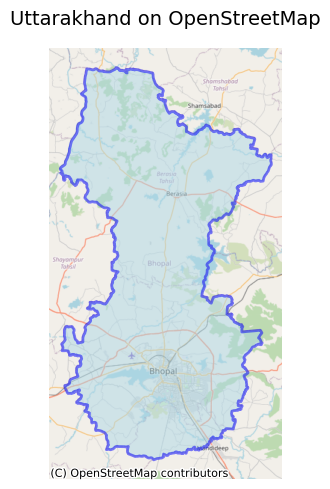

In [976]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # For OSM basemaps

# Load the GeoJSON boundary
gdf = gpd.read_file("prayagraj_area.geojson")

# Project to Web Mercator for tile overlay
gdf = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, facecolor='lightblue', edgecolor='blue', linewidth=2, alpha=0.5)

# Add OpenStreetMap tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Clean up
ax.set_title("Uttarakhand on OpenStreetMap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [977]:
import requests
import json

# 🔐 Your credentials
client_id = 'sh-dad2fc56-797f-4f2b-8c8d-bd4fe12e485e'
client_secret = 'CxAZRHS8bOS8WGjm6mZHcSGVbVjV9Qp0'
gdf = gdf.to_crs(epsg=4326)
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
bbox = [float(min_lon), float(min_lat), float(max_lon), float(max_lat)]



# 🌐 Get access token
token_response = requests.post(
    "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
    headers={"Content-Type": "application/x-www-form-urlencoded"},
    data={
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret
    }
)

access_token = token_response.json()["access_token"]

# ⚙️ Step 2: Set headers
headers = {
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/json"
}

# 🧠 Step 3: Evalscript (NDVI, NDBI, MNDWI, SAVI)
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "B08", "B11"],
    output: {
      bands: 4,
      sampleType: "FLOAT32"
    }
  };
}

function evaluatePixel(sample) {
  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  let ndbi = (sample.B11 - sample.B08) / (sample.B11 + sample.B08);
  let mndwi = (sample.B03 - sample.B11) / (sample.B03 + sample.B11);
  let L = 0.5;
  let savi = ((sample.B08 - sample.B04) / (sample.B08 + sample.B04 + L)) * (1 + L);
  return [ndvi, ndbi, mndwi, savi,sample.B04, sample.B03, sample.B02];
}
"""

# 🛰️ Step 4: Process request
payload = {
    "input": {
        "bounds": {
            "bbox": bbox,
            "properties": {
                "crs": "http://www.opengis.net/def/crs/EPSG/0/4326"
            }
        },
        "data": [{
            "type": "sentinel-2-l2a",
            "dataFilter": {
                "timeRange": {
                    "from": "2024-12-01T00:00:00Z",
                    "to": "2024-12-10T23:59:59Z"
                },
                "maxCloudCoverage": 20
            }
        }]
    },
    "output": {
        "width": 512,
        "height": 512,
        "responses": [{
            "identifier": "default",
            "format": {
                "type": "image/tiff"
            }
        }]
    },
    "evalscript": evalscript
}

response = requests.post(
    url="https://sh.dataspace.copernicus.eu/api/v1/process",
    headers=headers,
    data=json.dumps(payload)
)

# 💾 Step 5: Save the raster
with open("combined_indices.tif", "wb") as f:
    f.write(response.content)

print("✅ Combined raster (NDVI, NDBI, MNDWI, SAVI) saved as 'combined_indices.tif'")


✅ Combined raster (NDVI, NDBI, MNDWI, SAVI) saved as 'combined_indices.tif'


nan


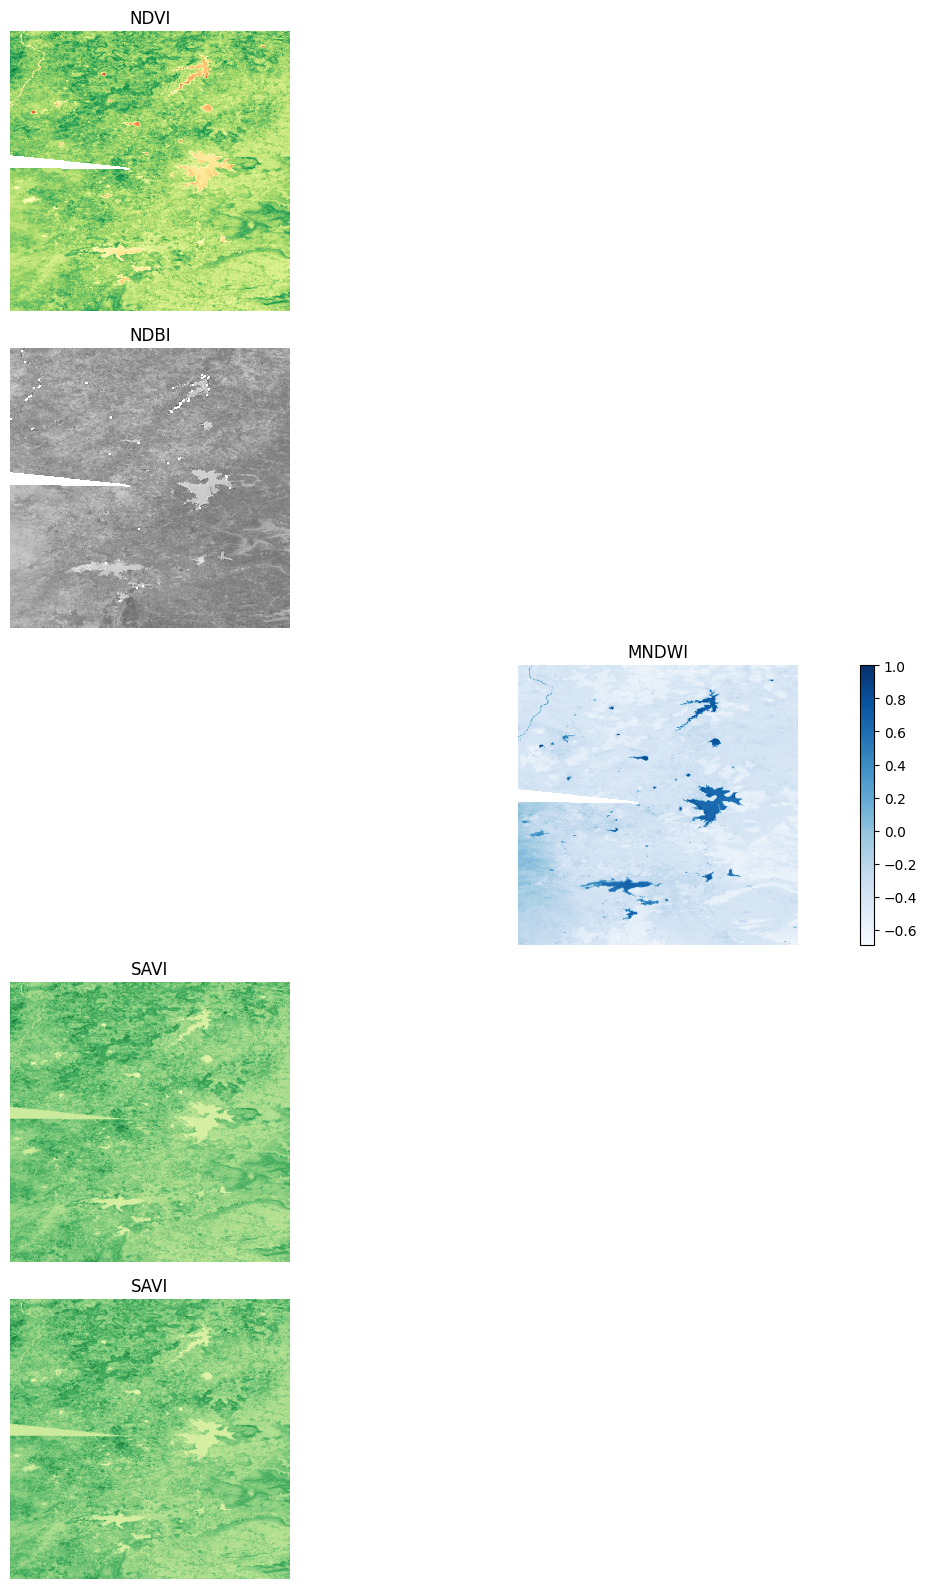

In [978]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
with rasterio.open("combined_indices.tif") as src:
    ndvi = src.read(1)
    ndbi = src.read(2)
    mndwi = src.read(3)
    savi = src.read(4)
    
print(np.mean(mndwi))
fig, axes = plt.subplots(5,  figsize=(16, 16))

axes[0].imshow(ndvi, cmap="RdYlGn")
axes[ 0].set_title("NDVI")
axes[ 0].axis("off")

axes[1].imshow(ndbi, cmap="Greys")
axes[1].set_title("NDBI")
axes[1].axis("off")


im=axes[2].imshow(mndwi, cmap="Blues")
axes[2].set_title("MNDWI")
axes[2].axis("off")
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)


axes[3].imshow(savi, cmap="YlGn")
axes[3].set_title("SAVI")
axes[3].axis("off")

axes[4].imshow(savi, cmap="YlGn")
axes[4].set_title("SAVI")
axes[4].axis("off")

plt.tight_layout()
plt.show()


In [979]:
np.nanmax( mndwi.flatten())

np.float32(1.0)

In [980]:
# import rasterio
# import numpy as np

# # Define your weights (adjust as per importance of each index)
# w_ndvi = 0.25
# w_ndbi = 0.05
# w_mndwi = 0.45
# w_savi = 0.25

# # --- Read the 4-band raster ---
# with rasterio.open("combined_indices.tif") as src:
#     ndvi = src.read(1).astype(np.float32)
#     ndbi = src.read(2).astype(np.float32)
#     mndwi = src.read(3).astype(np.float32)
#     savi = src.read(4).astype(np.float32)
#     profile = src.profile.copy()

# # --- Calculate weighted average ---

# weighted_avg = (
#     w_ndvi * ndvi +
#     w_ndbi * ndbi +
#     w_mndwi * mndwi +
#     w_savi * savi
# )

# # --- Update profile for 1-band output ---
# profile.update({
#     "count": 1,
#     "dtype": "float32"
# })

# # --- Save new raster ---
# with rasterio.open("weighted_average.tif", "w", **profile) as dst:
#     dst.write(weighted_avg, 1)

# print("✅ Saved single-band weighted raster as 'weighted_average.tif'")


In [981]:

# import osmnx as ox
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import numpy as np
# from shapely.geometry import box
# from matplotlib.colors import ListedColormap

# # Bounding box: [min_lon, min_lat, max_lon, max_lat] (e.g., around Agra)

# # Create a shapely box from bbox
# geom = box(*bbox)
# bbox_gdf = gpd.GeoDataFrame(geometry=[geom], crs="EPSG:4326")

# # Define the tags to fetch water features
# tags = {"waterway": True}  # rivers, canals, streams etc.

# # Correct call using OSMnx v2.x
# rivers = ox.features.features_from_polygon(geom, tags=tags)

# # --- Dummy landcover for demonstration ---
# classified_image =landcover

# # Create color map
# cmap = ListedColormap(["beige", "lightgreen", "gray", "blue"])
# labels = ["Background", "Forest", "Urban", "Water"]

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 10))
# im = ax.imshow(classified_image, cmap=cmap)

# # Overlay OSM rivers
# rivers.to_crs("EPSG:4326").plot(ax=ax, color='blue', linewidth=1, label='Rivers')

# # Colorbar
# cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
# cbar.ax.set_yticklabels(labels)

# plt.title("Land Cover Classification with OSM Rivers")
# plt.axis("off")
# plt.legend()
# plt.show()


In [982]:
# import osmnx as ox
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# import geopandas as gpd
# import numpy as np

# # --- Step 1: Your existing landcover map ---
# # (Use your already defined landcover, ndvi, mndwi, ndbi arrays here)
# # Sample if you need to simulate:
# # landcover = np.zeros((height, width), dtype=np.uint8)

# # --- Step 2: Define your location or bounding box ---
# place_name = "mirzapur, India"  # or any other location you used

# # Get river geometries
# tags = {"waterway": "river"}
# river_gdf = ox.features_from_place(place_name, tags)

# # Ensure geometries are LineStrings or MultiLineStrings
# river_gdf = river_gdf[river_gdf.geometry.type.isin(["LineString", "MultiLineString"])]

# # --- Step 3: Plot landcover with rivers overlay ---
# # Define color map
# cmap = ListedColormap(["beige", "lightgreen", "blue", "darkgreen"])
# labels = ["Background", "Forest", "Water", "Dense Forest"]

# # Plot
# fig, ax = plt.subplots(figsize=(10, 10))
# im = ax.imshow(landcover, cmap=cmap)

# # Add OSM rivers
# river_gdf.plot(ax=ax, color="cyan", linewidth=1.5, label="OSM Rivers")

# # Colorbar
# cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
# cbar.ax.set_yticklabels(labels)

# plt.legend(loc="lower right")
# plt.title("Land Cover Classification with OSM Rivers Overlay")
# plt.axis("off")
# plt.tight_layout()
# plt.show()


In [983]:
# import rasterio
# import numpy as np
# import geopandas as gpd
# from rasterio.mask import mask
# import matplotlib.pyplot as plt

# # --- Load GeoJSON AOI ---
# gdf = gpd.read_file("prayagraj_area.geojson")
# geometry = [gdf.geometry[0].__geo_interface__]

# # --- Mask the raster using the AOI ---
# with rasterio.open("weighted_average.tif") as src:
#     out_image, out_transform = mask(src, geometry, crop=True)
#     masked_array = out_image[0].astype(float)

# # --- Convert masked values to NaN for plotting
# # masked_array[masked_array == src.nodata] = 100  # This ensures nodata is transparent

# # --- Create colormap and set NaN to white
# cmap = plt.get_cmap("YlGnBu").copy()  # Copy so we can modify
# # cmap.set_bad(color='black')          # Set color for NaNs (outside AOI)

# # --- Plot
# fig, ax = plt.subplots(figsize=(5, 5))
# img = ax.imshow(masked_array, cmap=cmap, )

# # Overlay AOI boundary
# gdf.boundary.plot(ax=ax, color='white', linewidth=4)

# # Add colorbar
# cbar = plt.colorbar(img, ax=ax, label="Weighted Index")

# # Display settings
# ax.set_title("Weighted Index with AOI Mask & Boundary", fontsize=14)
# ax.axis("off")
# plt.tight_layout()
# plt.show()


In [984]:
# raster_path = "combined_indices.tif"
# src = rasterio.open(raster_path)
# raster = src.read(1)
# raster_crs = src.crs


In [985]:
bbox


[77.16566379999999, 23.072504699999996, 77.64852049999999, 23.8953516]

In [986]:
# import osmnx as ox
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from shapely.geometry import box
# from matplotlib.colors import ListedColormap

# # Step 1: Define your bounding box [min_lon, min_lat, max_lon, max_lat]
# # bbox = [77.85, 26.85, 78.15, 27.15]  # Example: Agra region

# # Step 2: Create bounding box geometry
# bbox_geom = box(*bbox)
# bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:4326")

# # Step 3: Get OSM data and clip to bbox
# tags = {
#     "landuse": ["residential", "commercial", "industrial"],
#     "waterway": "river",
#     "natural": "water"
# }
# osm = ox.features_from_polygon(bbox_geom, tags=tags)

# # Filter and separate geometries
# urban = osm[osm['landuse'].notnull()].copy()
# rivers = osm[osm['waterway'] == 'river'].copy()

# # Step 4: Clip OSM features to bbox
# urban = gpd.overlay(urban, bbox_gdf, how='intersection')
# rivers = gpd.overlay(rivers, bbox_gdf, how='intersection')

# # Step 5: Assume you have a NumPy classified image called `classified_image`
# # For example, shape of classified_image = (512, 512), dtype=uint8
# # Assume it's already georeferenced (covers the bbox region)
# # 0 = background, 1 = forest, 2 = urban, 3 = water, etc.

# # Define the color map
# cmap = ListedColormap(["beige", "lightgreen", "red", "blue", "darkgreen"])
# labels = ["Background", "Forest", "Urban", "Water", "Dense Forest"]

# # Step 6: Plotting
# fig, ax = plt.subplots(figsize=(10, 10))
# im = ax.imshow(landcover, cmap=cmap, extent=bbox)

# # Overlay OSM features
# rivers.plot(ax=ax, color='blue', linewidth=1.5, label="Rivers")
# urban.plot(ax=ax, color='red', alpha=0.7, label="Urban")

# # Add legend and formatting
# cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3, 4])
# cbar.ax.set_yticklabels(labels)
# plt.title("Landcover Classification with OSM Features")
# plt.legend()
# plt.axis("off")
# plt.tight_layout()
# plt.show()


In [987]:
# import osmnx as ox
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from shapely.geometry import box
# from matplotlib.colors import ListedColormap

# # Bounding box in (min_lon, min_lat, max_lon, max_lat)
# # bbox = [77.85, 26.85, 78.15, 27.15]  # Example for Agra
# bbox_geom = box(*bbox)
# bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:4326")

# # Tags for OSM data
# tags = {
#     "landuse": ["residential", "commercial", "industrial"],
#     "waterway": "river"
# }

# # Fetch and separate geometries
# osm = ox.features_from_polygon(bbox_geom, tags=tags)
# lines = osm[osm.geometry.geom_type.isin(["LineString", "MultiLineString"])].copy()
# polygons = osm[osm.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()

# # Clip each geometry type separately
# if not lines.empty:
#     lines = gpd.clip(lines, bbox_gdf)

# if not polygons.empty:
#     polygons = gpd.clip(polygons, bbox_gdf)

# # Your NumPy classified image (replace this with your actual array)
# # classified_image = np.load("classified.npy") or however you have it
# # For example purposes:
# # classified_image = np.random.randint(0, 5, (500, 500), dtype=np.uint8)

# # Define color map and labels
# cmap = ListedColormap(["beige", "lightgreen", "red", "blue", "darkgreen"])
# labels = ["Background", "Forest", "Urban", "Water", "Dense Forest"]

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 10))
# im = ax.imshow(classified_image, cmap=cmap, extent=bbox)

# if not lines.empty:
#     lines.plot(ax=ax, color='blue', linewidth=1.5, label='Rivers')

# if not polygons.empty:
#     polygons.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.2, label='Urban Areas')

# # Colorbar with fixed tick labels
# cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3, 4])
# cbar.ax.set_yticklabels(labels)

# plt.title("Land Cover Classification with OSM Features", fontsize=14)
# plt.axis("off")
# plt.legend(loc='lower right', fontsize=10, frameon=True)
# plt.tight_layout()
# plt.show()


In [988]:
# import osmnx as ox
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import rasterio
# from shapely.geometry import box
# import numpy as np
# from matplotlib.colors import ListedColormap
# from shapely.affinity import affine_transform

# # --- STEP 1: Load Raster Metadata ---
# with rasterio.open("combined_indices.tif") as src:
#     raster_crs = src.crs
#     raster_bounds = src.bounds
#     transform = src.transform
#     height, width = src.height, src.width

# # Dummy landcover array (replace with actual landcover)
# landcover = np.zeros((height, width), dtype=np.uint8)
# landcover[100:150, 100:150] = 1
# landcover[200:300, 200:300] = 2
# landcover[50:80, 400:450] = 3

# # --- STEP 2: Fetch OSM Data ---
# place = "mirzapur, India"
# tags = {
#     "landuse": ["residential", "commercial", "industrial"],
#     "waterway": "river"
# }
# osm = ox.features_from_place(place, tags).to_crs(raster_crs)

# # --- STEP 3: Clip to Raster Extent ---
# bbox_geom = box(*raster_bounds)
# bbox = gpd.GeoDataFrame(geometry=[bbox_geom], crs=raster_crs)
# osm = gpd.clip(osm, bbox)

# # --- STEP 4: Separate and Transform Geometries to Pixel Space ---
# inverse_transform = ~transform  # This gives the inverse affine transform
# affine_params = [inverse_transform.a, inverse_transform.b, 
#                  inverse_transform.d, inverse_transform.e, 
#                  inverse_transform.xoff, inverse_transform.yoff]

# def to_pixel_coords(gdf):
#     return gdf.copy().set_geometry(
#         gdf.geometry.apply(lambda geom: affine_transform(geom, affine_params))
#     )

# rivers = osm[osm.geometry.type.isin(["LineString", "MultiLineString"])].copy()
# urban = osm[osm.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

# rivers_px = to_pixel_coords(rivers)
# urban_px = to_pixel_coords(urban)

# # --- STEP 5: Plot ---
# cmap = ListedColormap(["beige", "green", "red", "blue"])
# labels = ["Background", "Forest", "Urban", "Water"]

# fig, ax = plt.subplots(figsize=(10, 10))
# im = ax.imshow(landcover, cmap=cmap)

# if not rivers_px.empty:
#     rivers_px.plot(ax=ax, color='blue', linewidth=1.0, label="Rivers")

# if not urban_px.empty and "landuse" in urban_px.columns:
#     urban_px[urban_px["landuse"].notnull()].plot(
#         ax=ax, edgecolor='red', facecolor='none', linewidth=1.5, label="Urban"
#     )

# cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
# cbar.ax.set_yticklabels(labels)

# plt.title("Land Cover with Aligned OSM Rivers and Urban")
# plt.axis("off")
# plt.legend()
# plt.tight_layout()
# plt.show()


In [989]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import box
from rasterio.features import rasterize
from scipy.ndimage import binary_dilation
height, width = src.height, src.width
# --- Step 1: Define Place and Tags ---
place = location
tags = {
    "landuse": ["residential", "commercial", "industrial"],
    "waterway": "river",
    "natural": "water"
}

# --- Step 2: Fetch OSM Features ---
osm_gdf = ox.features_from_place(place, tags)

# --- Step 3: Open Raster, Get CRS and Bounding Box ---
with rasterio.open("combined_indices.tif") as src:
    raster_crs = src.crs
    raster_bounds = src.bounds
    bbox_geom = box(*raster_bounds)
    bbox = gpd.GeoDataFrame(geometry=[bbox_geom], crs=raster_crs)

    # Reproject OSM to raster CRS
    osm_gdf = osm_gdf.to_crs(raster_crs)

    # --- Step 4: Filter + Clip ---
    river_geom = osm_gdf[osm_gdf.geometry.type.isin(["LineString", "MultiLineString"])].copy()
    polygon_geom = osm_gdf[osm_gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

    # Reset index to avoid overlay errors
    bbox = bbox.reset_index(drop=True)
    river_geom = river_geom.reset_index(drop=True)
    polygon_geom = polygon_geom.reset_index(drop=True)

    # Clip both geometries
    if not river_geom.empty:
        river_geom = gpd.clip(river_geom, bbox)

    if not polygon_geom.empty:
        polygon_geom = gpd.clip(polygon_geom, bbox)

    # --- Step 5: Plot ---
rivers_buffered = river_geom.copy()
# rivers_buffered['geometry'] = rivers_buffered.buffer(15)  # e.g., 100 or 250

river_mask = rasterize(
    [(geom, 1) for geom in rivers_buffered.geometry],
    out_shape=(height, width),
    transform=src.transform,
    fill=0,
    dtype=np.uint8
)
# widened_river_mask = binary_dilation(river_mask, iterations=1).astype(np.uint8)


In [990]:


tags = {
    "landuse": ["residential", "commercial", "industrial"],
    "waterway": "river",
    "natural": ["water", "wetland"],
}

# --- Step 2: Fetch OSM Features ---
osm_gdf = ox.features_from_place(place, tags)

# --- Step 3: Open Raster, Get CRS and Bounding Box ---
with rasterio.open("combined_indices.tif") as src:
    raster_crs = src.crs
    raster_bounds = src.bounds
    bbox_geom = box(*raster_bounds)
    bbox = gpd.GeoDataFrame(geometry=[bbox_geom], crs=raster_crs)

    # Reproject OSM to raster CRS
    osm_gdf = osm_gdf.to_crs(raster_crs)

    # --- Step 4: Filter + Clip ---
    river_geom = osm_gdf[osm_gdf.geometry.type.isin(["LineString", "MultiLineString"])].copy()
    polygon_geom = osm_gdf[osm_gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

    # Reset index to avoid overlay errors
    bbox = bbox.reset_index(drop=True)
    river_geom = river_geom.reset_index(drop=True)
    polygon_geom = polygon_geom.reset_index(drop=True)

    # Clip both geometries
    if not river_geom.empty:
        river_geom = gpd.clip(river_geom, bbox)

    if not polygon_geom.empty:
        polygon_geom = gpd.clip(polygon_geom, bbox)

    # --- Step 5: Plot ---
rivers_buffered = river_geom.copy()
# rivers_buffered['geometry'] = rivers_buffered.buffer(15)  # e.g., 100 or 250

water_mask = rasterize(
    [(geom, 1) for geom in rivers_buffered.geometry],
    out_shape=(height, width),
    transform=src.transform,
    fill=0,
    dtype=np.uint8
)
# water_mask = binary_dilation(water_mask, iterations=1).astype(np.uint8)


In [991]:
tags = {
    "landuse": ["residential", "commercial", "industrial", "retail"],
    "building": True,  # gets any building footprints
    "highway": ["living_street", "residential", "primary", "secondary", "tertiary"]  # roads in urban fabric
}

# Step 2: Fetch OSM urban polygons
osm_gdf = ox.features_from_place(place, tags=tags)

# Step 3: Filter only polygon geometries

urban_polygons = osm_gdf[osm_gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

# Step 4: Reproject to raster CRS
urban_polygons = urban_polygons.to_crs(raster_crs)

# Step 5: Clip urban areas to raster bounds
bbox_geom = box(*raster_bounds)
bbox = gpd.GeoDataFrame(geometry=[bbox_geom], crs=raster_crs)
urban_clipped = gpd.clip(urban_polygons, bbox)

# Step 6: Rasterize urban polygons
urban_mask = rasterize(
    [(geom, 1) for geom in urban_clipped.geometry],
    out_shape=(height, width),
    transform=src.transform,
    fill=0,
    dtype=np.uint8
)

nan


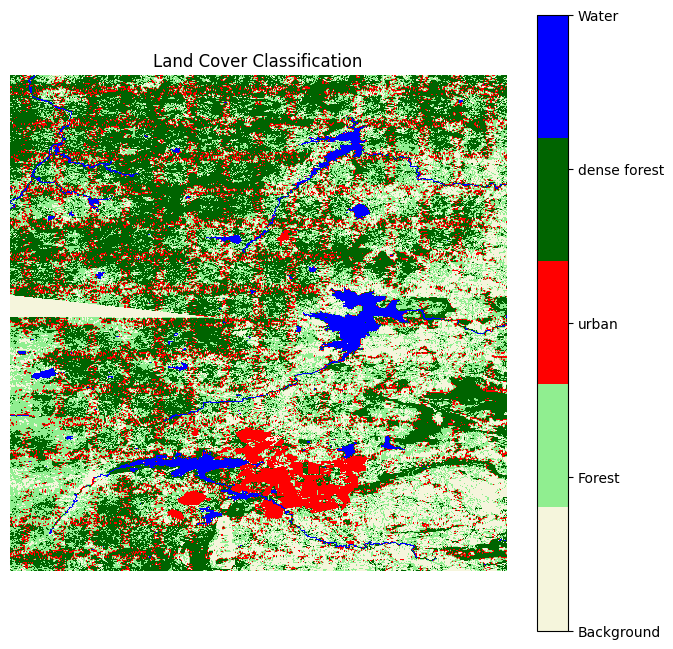

In [992]:

from matplotlib.colors import ListedColormap

with rasterio.open("combined_indices.tif") as src:
    ndvi = src.read(1)
    ndbi = src.read(2)
    mndwi = src.read(3)
    savi = src.read(4)
    
#  Initialize a blank classification map
# 0: background, 1: forest, 2: urban, 3: water


w_th=(np.nanmax(mndwi)+np.nanmin(mndwi))*0.5
print(mndwi.max())
landcover = np.zeros_like(ndvi, dtype=np.uint8)

# Apply rules
landcover[(ndvi > 0.2) & (ndbi < 0.2)] = 1  # Forest
landcover[(ndvi > 0.4) & (ndbi < 0.2)] = 3  # dense Forest
landcover[(ndvi > 0.4) & (ndbi < 0.2)] = 3  # dense Forest

landcover[(urban_mask==1)|(ndbi > 0.5) & (ndvi < 0.2) & (mndwi < w_th)] = 2  # Urban
landcover[(river_mask==1 )|(water_mask==1 ) |(mndwi>w_th)] = 4                 # Water

# Define color map
cmap = ListedColormap(["beige", "lightgreen", "red","darkgreen","blue"])
labels = ["Background", "Forest","urban","dense forest","Water"]

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(landcover, cmap=cmap)

cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3,4])
cbar.ax.set_yticklabels(labels)
plt.title("Land Cover Classification")
plt.axis("off")
plt.show()

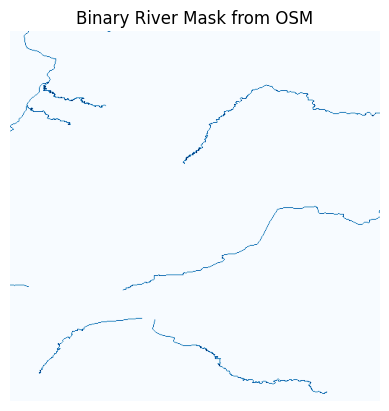

In [993]:
import matplotlib.pyplot as plt

plt.imshow(water_mask, cmap="Blues")
plt.title("Binary River Mask from OSM")
plt.axis("off")
plt.show()


In [994]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
from shapely.geometry import box

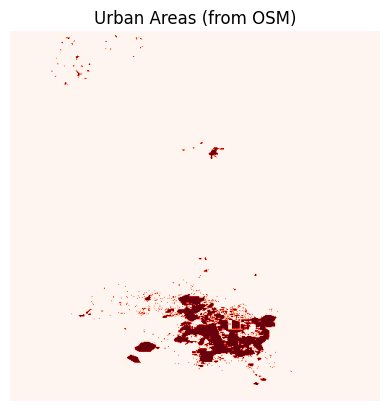

In [995]:



# Step 7: Display the urban mask
plt.imshow(urban_mask, cmap="Reds")
plt.title("Urban Areas (from OSM)")
plt.axis("off")
plt.show()